Simple simulated PPG to heart rate to get things going.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# 1. Generate synthetic multi-wavelength time series data
n_samples = 1000
seq_len = 100  # length of each time series
channels = 3   # green, red, IR

# Simulate signals with sine waves and noise
def simulate_ppg_waveform(freq, noise=0.05):
    t = np.linspace(0, 1, seq_len)
    return np.sin(2 * np.pi * freq * t) + noise * np.random.randn(seq_len)

X = np.zeros((n_samples, channels, seq_len))
y = np.zeros(n_samples)

np.random.seed(42)
for i in range(n_samples):
    mean_hr = 75  # mean resting HR in bpm
    std_dev_hr = 10  # standard deviation in bpm
    hr = np.random.normal(mean_hr, std_dev_hr)  # generate HR with normal distribution
    freq = hr / 60  # convert to Hz
    X[i, 0, :] = simulate_ppg_waveform(freq, noise=0.1)  # green
    X[i, 1, :] = simulate_ppg_waveform(freq, noise=0.12)  # red
    X[i, 2, :] = simulate_ppg_waveform(freq, noise=0.15)  # IR
    y[i] = hr

X.shape

(1000, 3, 100)

In [3]:
# Train/test split
split = int(0.8 * n_samples)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


(800, 3, 100)
(800,)
(200, 3, 100)
(200,)


In [4]:

# 2. Define CNN model
class PPGCNN(nn.Module):
    def __init__(self):
        super(PPGCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(16, 1)

    def forward(self, x):
        x = self.relu(self.conv1(x))      # [B, 16, 100]
        x = self.pool(x)                  # [B, 16, 1]
        x = x.view(x.size(0), -1)         # [B, 16]
        x = self.fc(x)                    # [B, 1]
        return x



In [5]:
class PPGTransformer(nn.Module):
    def __init__(self, seq_len=100, n_channels=3, d_model=64, nhead=4, num_layers=2):
        super(PPGTransformer, self).__init__()
        
        self.input_proj = nn.Linear(n_channels, d_model)  # [B, 100, 3] -> [B, 100, 64]
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [B, C, T] --> permute to [B, T, C] for transformer
        x = x.permute(0, 2, 1)  # [B, 100, 3]
        x = self.input_proj(x)  # [B, 100, 64]
        x = self.transformer(x)  # [B, 100, 64]
        x = x.mean(dim=1)        # Global average pooling over sequence: [B, 64]
        x = self.regressor(x)    # [B, 1]
        return x

In [6]:
# 3. Train the model
model = PPGCNN()
#model = PPGTransformer()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss:.2f}")

# 4. Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).squeeze().numpy()
    targets = y_test_tensor.squeeze().numpy()
    mae = np.mean(np.abs(preds - targets))
    print(f"\nTest MAE: {mae:.2f} bpm")



Epoch 1/100, Loss: 132968.40
Epoch 2/100, Loss: 92921.01
Epoch 3/100, Loss: 31889.20
Epoch 4/100, Loss: 2797.31
Epoch 5/100, Loss: 1687.97
Epoch 6/100, Loss: 1504.30
Epoch 7/100, Loss: 1474.41
Epoch 8/100, Loss: 1444.64
Epoch 9/100, Loss: 1415.87
Epoch 10/100, Loss: 1385.76
Epoch 11/100, Loss: 1359.99
Epoch 12/100, Loss: 1336.39
Epoch 13/100, Loss: 1312.48
Epoch 14/100, Loss: 1287.76
Epoch 15/100, Loss: 1264.71
Epoch 16/100, Loss: 1240.20
Epoch 17/100, Loss: 1221.94
Epoch 18/100, Loss: 1201.84
Epoch 19/100, Loss: 1188.96
Epoch 20/100, Loss: 1175.10
Epoch 21/100, Loss: 1156.33
Epoch 22/100, Loss: 1143.24
Epoch 23/100, Loss: 1146.02
Epoch 24/100, Loss: 1129.46
Epoch 25/100, Loss: 1107.17
Epoch 26/100, Loss: 1095.70
Epoch 27/100, Loss: 1085.25
Epoch 28/100, Loss: 1076.86
Epoch 29/100, Loss: 1066.86
Epoch 30/100, Loss: 1058.39
Epoch 31/100, Loss: 1060.07
Epoch 32/100, Loss: 1059.14
Epoch 33/100, Loss: 1038.75
Epoch 34/100, Loss: 1045.65
Epoch 35/100, Loss: 1032.71
Epoch 36/100, Loss: 1021.

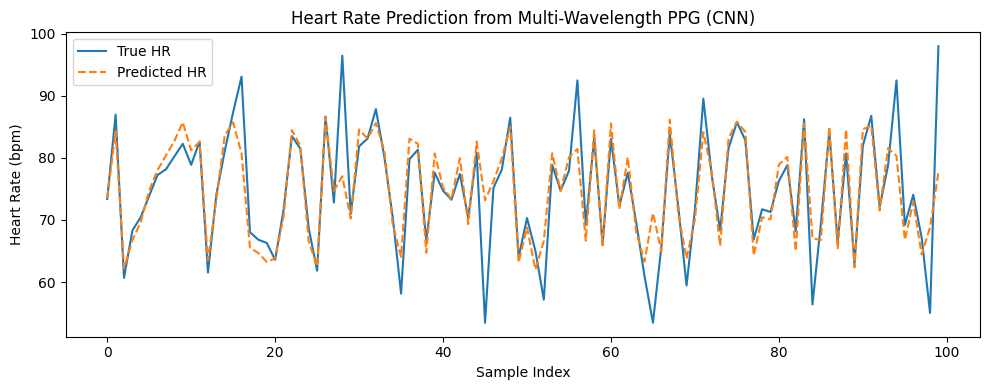

<Figure size 640x480 with 0 Axes>

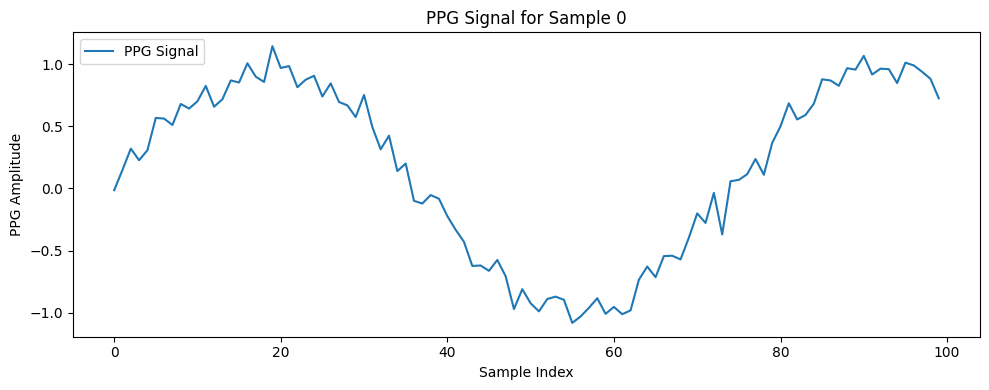

In [7]:
# 5. Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(targets[:100], label="True HR")
plt.plot(preds[:100], label="Predicted HR", linestyle='--')
plt.title("Heart Rate Prediction from Multi-Wavelength PPG (CNN)")
plt.xlabel("Sample Index")
plt.ylabel("Heart Rate (bpm)")
plt.legend()
plt.tight_layout()
plt.show()
plt.clf()  # Clear the figure to avoid any interference with the next plot

# 6. Plot PPG data
plt.figure(figsize=(10, 4))
plt.plot(X[0,0,:], label="PPG Signal")  # Assuming X is your input PPG data
plt.title("PPG Signal for Sample 0")
plt.xlabel("Sample Index")
plt.ylabel("PPG Amplitude")
plt.legend()
plt.tight_layout()
plt.show()  # Display the second plot